In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch

from sklearn.model_selection import train_test_split

In [2]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
data = pd.read_csv("data.csv")

print(data.shape)
data.head()

(4657, 4)


,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [4]:
data.drop(columns = ["index"], inplace = True)

In [5]:
num_labels = len(data.genre.unique())
print("num labels: ", num_labels)
genre2id = {genre: i for i, genre in enumerate(data.genre.unique())}
id2genre = {i: genre for i, genre in enumerate(data.genre.unique())}

num labels:  10


In [6]:
import re

def clean_text(text):
    text = re.sub('[^a-zA-Z0-9\.\,\?\!]', ' ', str(text).lower()) # remove all except lowercase, uppercase, digits, punctuation
    text = re.sub('\[.*?\]', '', text) # remove any text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove any links present 
    text = re.sub('\n', ' ', text) # remove the next line character
    text = re.sub('\w*\d\w*', '', text) # remove the words contaitning numbers
    text = re.sub('\s+', ' ', text) # remove extra spaces
    
    return text

In [7]:
data["summary"] = data["summary"].apply(clean_text)
data.head()

,title,genre,summary
0,Drowned Wednesday,fantasy,drowned wednesday is the first trustee among ...
1,The Lost Hero,fantasy,"as the book opens, jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,cugel is easily persuaded by the merchant fia...
3,Magic's Promise,fantasy,the book opens with herald mage vanyel return...
4,Taran Wanderer,fantasy,taran and gurgi have returned to caer dallben...


In [8]:
data["genre_id"] = data["genre"].apply(lambda a: genre2id[a])

In [9]:
data["genre"].value_counts()

thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: genre, dtype: int64

In [10]:
fantasy_summaries = data[data["genre_id"] == 0]
science_summaries = data[data["genre_id"] == 1]
crime_summaries = data[data["genre_id"] == 2]
history_summaries = data[data["genre_id"] == 3]
horror_summaries = data[data["genre_id"] == 4]
thriller_summaries = data[data["genre_id"] == 5]
psychology_summaries = data[data["genre_id"] == 6]
romance_summaries = data[data["genre_id"] == 7]
sports_summaries = data[data["genre_id"] == 8]
travel_summaries = data[data["genre_id"] == 9]

In [11]:
from sklearn.utils import resample

fantasy_downsample = resample(fantasy_summaries,
                              replace=False,
                              n_samples=300,
                              random_state=42)

science_downsample = resample(science_summaries,
                              replace=False,
                              n_samples=300,
                              random_state=42)

crime_downsample = resample(crime_summaries,
                              replace=False,
                              n_samples=300,
                              random_state=42)

history_downsample = resample(history_summaries,
                              replace=False,
                              n_samples=300,
                              random_state=42)

horror_downsample = resample(horror_summaries,
                              replace=False,
                              n_samples=300,
                              random_state=42)

thriller_downsample = resample(thriller_summaries,
                              replace=False,
                              n_samples=300,
                              random_state=42)

psychology_downsample = resample(psychology_summaries,
                              replace=False,
                              n_samples=80,
                              random_state=42)

romance_downsample = resample(romance_summaries,
                              replace=False,
                              n_samples=80,
                              random_state=42)

sports_downsample = resample(sports_summaries,
                              replace=False,
                              n_samples=80,
                              random_state=42)

travel_downsample = resample(travel_summaries,
                              replace=False,
                              n_samples=80,
                              random_state=42)

In [12]:
train = pd.concat([fantasy_downsample, science_downsample, crime_downsample, history_downsample, horror_downsample, thriller_downsample, psychology_downsample, romance_downsample, sports_downsample, travel_downsample])

In [13]:
train["genre"].value_counts()

fantasy       300
science       300
crime         300
history       300
horror        300
thriller      300
psychology     80
romance        80
sports         80
travel         80
Name: genre, dtype: int64

In [14]:
test = data.loc[~data.index.isin(train.index)]

In [15]:
test["genre"].value_counts()

thriller      723
fantasy       576
science       347
history       300
horror        300
crime         200
romance        31
psychology     20
sports         20
travel         20
Name: genre, dtype: int64

In [16]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [17]:
train.head()

,title,genre,summary,genre_id
365,The Forest House,fantasy,"in the early days of the conquest, when the r...",0
4436,Heartless,fantasy,long before she was the terror of wonderland t...,0
4609,A Hat Full of Sky,fantasy,we see you. now we are you. no real witch woul...,0
4473,Going Postal,fantasy,arch swindler moist van lipwig never believed ...,0
213,Tithe : A Modern Faerie Tale,fantasy,tithe follows the story of sixteen year old a...,0


By now, data has been cleaned. Next step is to tokenize, train, and test.
The first step is to use TextRank from Gensim to rank the first few sentences, and then we will train on BERT and RoBERTA to see its' performance.

# Text Rank by Gensim:
Note that this could be skipped.

In [18]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.summarization import summarize
def text_rank(text,num):
    """
    Apply TextRank algorithm to summarize the given text.

    Args:
        text (str): The input text to be summarized.
        num (int): The desired number of sentences in the summary.

    Returns:
        str: The summarized text.

    """
    # Split the text into sentences
    sentences = sent_tokenize(text)
    
    # If the text has no sentences, return an empty string
    if len(sentences) == 0:
        return ''
    
    # If the text has less than four sentences, return the original text
    if len(sentences) < num:
        return text
    
    # Use gensim's summarize function, which implements TextRank. We ask for a summary that is 20% of the original length.
    summary = summarize(text, ratio=0.3)
    
    # Split the summary into sentences
    summary_sentences = summary.split('\n')
    
    # If the summary has no sentences, return an empty string
    if len(summary_sentences) == 0:
        return ''
    
    # Otherwise, return the first four sentences of the summary
    return ' '.join(summary_sentences[:num])


In [19]:

#Now we keep the first few sentences for each summary.

print("\n-----------------------before TextRank---------------------\n")
print(train["summary"][575])

print("\n-----------------------Progressing---------------------\n")
try:
    train["summary"] = train["summary"].apply(lambda x: text_rank(x, num=4))
except Exception as e:
    print("An error occurred while applying text_rank:", str(e))

    
print("\n-----------------------after TextRank---------------------\n")
print(train["summary"][575])


-----------------------before TextRank---------------------

 the blieder drive, a faster than light drive system, has permitted the population of earth to colonize the galaxy. each planet has become the home for a particular social group. four hundred years after the diaspora, a spaceship from earth visits three of the planets, the first steps to unifying the galaxy under a new empire. things do not go entirely as hoped, as the incompetent military authoritarians of the ship encounter three very different societies. the first planet was a penal colony it is now many independent kleptocratic despotisms preying on each other. the second planet, hygeia, is populated by health and fitness fanatic nudists. the third planet, kassim, was colonized by a religious group, but when the ship arrives, they can t find any human life, only empty villages overgrown by jungle. they decide not to land on the planet, because the captain fears that the colonists could have been killed by a disease and h

# Tokenize the data

In [17]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer

# Create a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize the text
def tokenize_text(df, max_length=512):
    # Tokenize the 'summary' column of the DataFrame using the tokenizer's batch_encode_plus method
    # df['summary'].tolist() converts the 'summary' column into a list of strings
    # max_length specifies the maximum length of the tokenized sequences
    # padding='max_length' pads the tokenized sequences to have a length of max_length
    # truncation=True truncates the tokenized sequences if they exceed the max_length
    return tokenizer.batch_encode_plus(
        df['summary'].tolist(), 
        max_length=max_length, 
        padding='max_length', 
        truncation=True
    )

tokenized_train_texts = tokenize_text(train)
tokenized_test_texts = tokenize_text(test)

In [18]:
#Then prepare the dataset and dataloader
from torch.utils.data import Dataset, DataLoader

class BookDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = BookDataset(tokenized_train_texts, train['genre_id'].values)
test_dataset = BookDataset(tokenized_test_texts, test['genre_id'].values)

# Create the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [19]:
print(tokenized_train_texts.keys())
print(len(tokenized_train_texts['input_ids']))
print(len(train['genre_id'].values))
#print(tokenized_train_texts['input_ids'][0])
print(train_dataset[1347])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
2120
2120
{'input_ids': tensor([  101, 24665, 16515, 19231,  2571,  2413,  2005, 10729,  2001,  2141,
         1999,  3000,  1010,  2605,  1010,  2251,  1997,  1012,  2010,  2388,
         3957,  4182,  2000,  2032,  2096,  2551,  2012,  1037,  3869, 13498,
         1012,  2016,  2038,  2018,  2445,  4182,  2176,  2335,  3130,  2096,
         2551,  1010,  2029,  2020,  2035,  2593,  2145, 17706, 26830,  2030,
         2379,  2757,  1010,  2061,  2016,  7659,  2010,  8529, 14454,  7476,
        11601,  1998,  3727,  2032,  2000,  3280,  1012,  2174,  1010, 24665,
        16515, 19231,  2571, 12842,  2041,  2013,  2503,  1996,  8632,  1997,
         3869,  4641,  1998, 18453,  1010,  1998,  2010,  2388,  2003,  3236,
         1010,  2699,  2005,  3674, 10527, 21752,  1010,  2179,  5905,  1998,
         2003, 11703,  9331, 15198,  1012,  2004,  1037,  2775,  1010, 24665,
        16515, 19231,  2571,  2003,  2979,  2247,  2367, 

# Initialize the model and train the model

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train['genre_id'].unique()))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

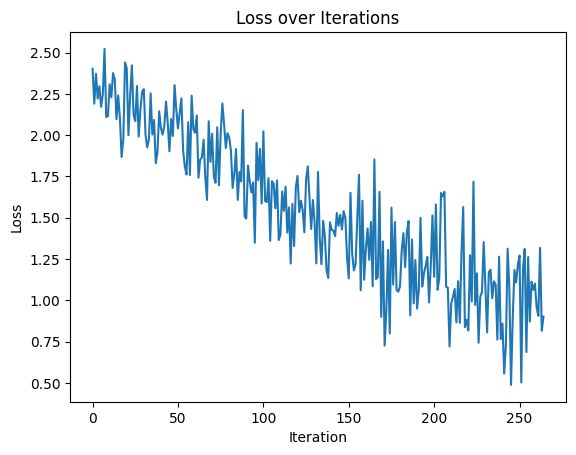

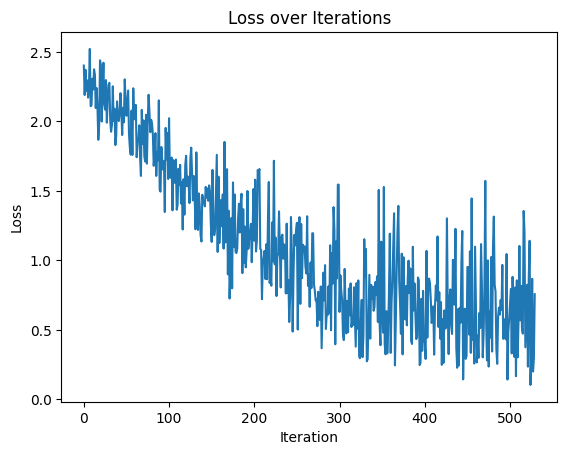

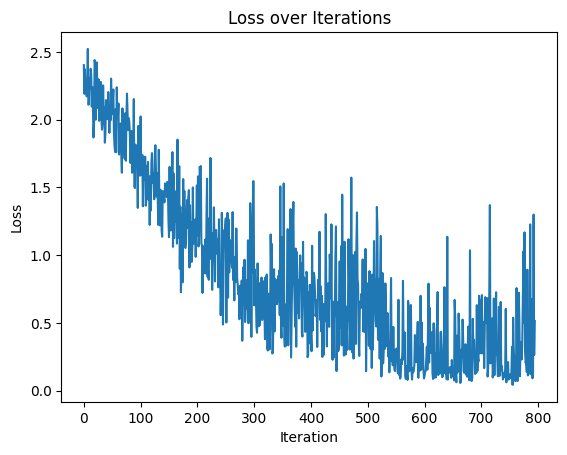

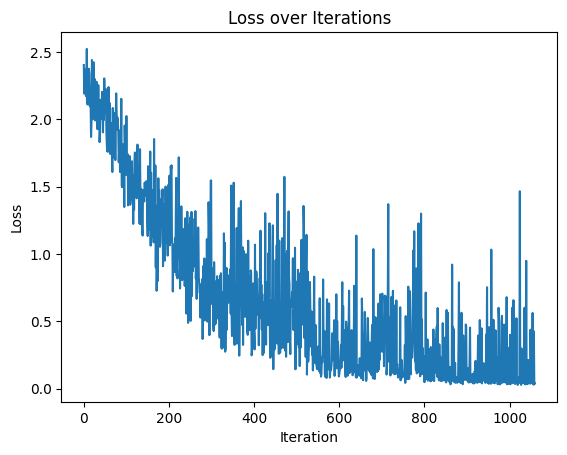

In [25]:
from torch.optim import Adam
import matplotlib.pyplot as plt

# Initialize the optimizer
optimizer = Adam(model.parameters(), lr=2e-5)

# Move the model to the GPU
model.to('cuda')

# Initialize a list to store the loss values
losses = []

# Assume best_loss is a very high initial value
best_loss = float('inf')

# Training loop
for epoch in range(4):  # Number of epochs
    for batch in train_dataloader:
        # Move batch tensors to the same device as the model
        batch = {k: v.to('cuda') for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Optimize the model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Check if this batch loss is the best we've seen
        current_loss = loss.item()
        if current_loss < best_loss:
            best_loss = current_loss
            torch.save(model.state_dict(), 'best_model.pt')
        
        # Append the loss value to the list
        losses.append(current_loss)

    # Plot the loss values after each epoch
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over Iterations')
    plt.show()


In [35]:
#Load the model
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [36]:
# Assuming you have a test dataset named test_dataloader
# Move the model to evaluation mode
model.eval()

# Move the model to the same device as the test data
model.to('cuda')

# Initialize a list to store the predictions
predictions = []


# Iterate over the test dataset
for batch in test_dataloader:
    # Move batch tensors to the same device as the model
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Disable gradient calculation
    with torch.no_grad():
        # Perform inference
        outputs = model(**batch)
    
    # Extract the predicted labels or values from the outputs
    # and add them to the predictions list
    predicted_values = outputs.logits
    predictions.extend(predicted_values)

In [37]:
aaa = predictions 

In [38]:
# Convert logits to predictions
predictions = [torch.argmax(item).item() for item in predictions]

true_labels = []

# Iterate over the test dataset
for batch in test_dataloader:
    # Extract labels and add them to true_labels
    true_labels.extend(batch['labels'].tolist())

# Make sure that true_labels is a list
assert isinstance(true_labels, list)

from sklearn.metrics import classification_report


In [39]:
aaa

[tensor([-0.6793,  0.7100, -0.6033, -1.2947,  5.0262,  2.0649, -1.5813, -1.1656,
         -1.0807, -1.9137], device='cuda:0'),
 tensor([ 0.1942,  0.1933, -1.9589,  1.9349, -1.7206, -0.5638, -0.3886, -1.4674,
         -0.5221,  4.0851], device='cuda:0'),
 tensor([-0.5159,  5.0549, -1.8834, -0.1811, -0.6305,  1.4915, -0.3645, -1.1636,
         -1.3440, -0.9728], device='cuda:0'),
 tensor([-1.4636, -0.4933, -0.6153, -1.2994,  0.2108,  5.6374, -1.0908,  0.7895,
          0.0119, -0.9649], device='cuda:0'),
 tensor([ 0.4156,  1.0120, -1.2974, -1.1472,  0.3392,  0.7713,  0.8617,  0.4601,
         -0.3891, -0.2716], device='cuda:0'),
 tensor([ 3.8186,  1.2813, -2.4355, -0.7169, -0.7186, -1.0724,  0.1379,  1.9841,
         -0.4992, -0.9816], device='cuda:0'),
 tensor([ 0.9892, -0.4625, -1.0375,  5.2017, -1.8836, -1.9602, -0.8615, -1.0843,
         -0.9070,  0.4609], device='cuda:0'),
 tensor([-1.5086,  0.8595,  3.6140,  0.3599,  0.7518,  1.5335, -1.9553, -1.8048,
         -1.6107, -2.1039], de

In [40]:

# Generate classification report
report = classification_report(true_labels, predictions)

print(report)


              precision    recall  f1-score   support

           0       0.21      0.19      0.20       576
           1       0.14      0.17      0.15       347
           2       0.08      0.07      0.08       200
           3       0.08      0.08      0.08       300
           4       0.11      0.13      0.12       300
           5       0.30      0.24      0.26       723
           6       0.00      0.00      0.00        20
           7       0.02      0.03      0.02        31
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        20

    accuracy                           0.17      2537
   macro avg       0.09      0.09      0.09      2537
weighted avg       0.18      0.17      0.17      2537



In [33]:
# Move the model to evaluation mode
model.eval()

# Move the model to the same device as the test data
model.to('cuda')

# Initialize a list to store the predictions
predictions = []

# Create a progress bar
progress_bar = tqdm(train_dataloader, desc='Predicting')

# Iterate over the test dataset
for batch in train_dataloader:
    # Move batch tensors to the same device as the model
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Disable gradient calculation
    with torch.no_grad():
        # Perform inference
        outputs = model(**batch)
    
    # Extract the predicted labels or values from the outputs
    # and add them to the predictions list
    predicted_values = outputs.logits
    predictions.extend(predicted_values)


# Convert logits to predictions
predictions = [torch.argmax(item).item() for item in predictions]

true_labels = []

# Iterate over the test dataset
for batch in train_dataloader:
    # Extract labels and add them to true_labels
    true_labels.extend(batch['labels'].tolist())

# Make sure that true_labels is a list
assert isinstance(true_labels, list)

from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(true_labels, predictions)

print(report)




Predicting:   0%|                                       | 0/265 [00:25<?, ?it/s]


              precision    recall  f1-score   support

           0       0.14      0.14      0.14       300
           1       0.15      0.15      0.15       300
           2       0.15      0.15      0.15       300
           3       0.12      0.12      0.12       300
           4       0.15      0.15      0.15       300
           5       0.15      0.14      0.14       300
           6       0.03      0.04      0.04        80
           7       0.03      0.03      0.03        80
           8       0.02      0.03      0.02        80
           9       0.05      0.05      0.05        80

    accuracy                           0.13      2120
   macro avg       0.10      0.10      0.10      2120
weighted avg       0.13      0.13      0.13      2120



In [ ]:
# Archive

'''
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import matplotlib.pyplot as plt

# Assuming your dataframes are named 'train' and 'test'
train_df = train
test_df = test

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create Datasets
max_len = 64
batch_size = 4
train_dataset = TextClassificationDataset(
    texts=train_df.summary.to_numpy(),
    labels=train_df.genre_id.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)
test_dataset = TextClassificationDataset(
    texts=test_df.summary.to_numpy(),
    labels=test_df.genre_id.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

# Create Dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

num_labels = train_df['genre_id'].nunique()

# Model and Optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
losses = []
epochs = 3

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

# Plot loss
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

'''



'''
# Define the loss function
loss_function = torch.nn.CrossEntropyLoss()

# Move the model to the GPU
model.to('cuda')

# Training loop
for epoch in range(5):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to('cuda') for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_examples = 0
        for batch in test_dataloader:
            batch = {k: v.to('cuda') for k, v in batch.items()}
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=1)
            labels = batch['labels']
            total_correct += (predictions == labels).sum().item()
            total_examples += len(labels)

        accuracy = total_correct / total_examples
        print(f"Epoch {epoch + 1} - Test Accuracy: {accuracy:.4f}")


'''


'''
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

class BertDataset(Dataset):
    def __init__(self, summary, targets, tokenizer, max_len):
        self.summary = summary
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.summary)
    
    def __getitem__(self, item):
        summary = str(self.summary[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          summary,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'summary_text': summary,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

    
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = BertDataset(
        summary=df.summary.to_numpy(),
        targets=df.genre_id.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

'''